# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [2]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
#from torchvision import transforms

In [3]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def get_dataloader(batch_size, image_size):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    data_dir='processed_celeba_small/'
    
    # TODO: Implement function and return a dataloader
    #image = Image.open(data_dir).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor()
        #transforms.Normalize(mean=[0.04, 0.04, 0.04],std=[0.02, 0.02, 0.02])
    ])
    
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    
    # TODO: Implement function and return a dataloader
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                             batch_size=batch_size,
                                             shuffle=True)
    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

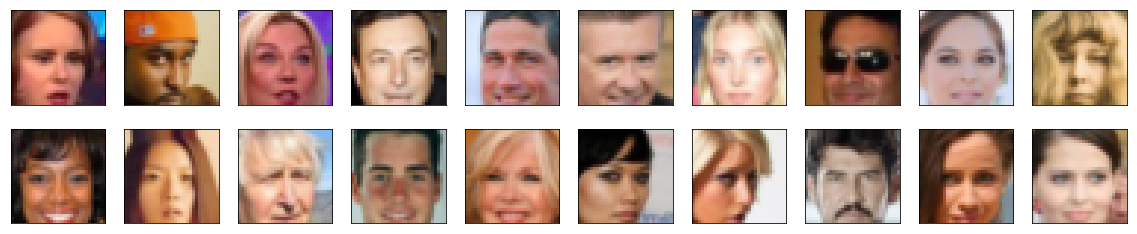

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    max, min = feature_range
    x = x * (max - min) + min
    return x


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

# conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [9]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # Define all convolutional layers
        # Should accept an RGB image as input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64 depth = 3
        self.conv2 = conv(conv_dim, conv_dim * 2, 4) # x, y = 32 depth = 64
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4) # x, y = 16 depth = 128
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        self.out = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        x = x.view(-1, self.conv_dim*4*4*4)
        
        x = self.fc(x)
        x = self.dropout(x)
        
        return x



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [10]:
#deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)


class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4 )
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        self.dropout = nn.Dropout(0.5)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        x = self.fc(x)
        x = self.dropout(x)
        
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.tanh(self.t_conv3(x))
        
        return x
        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [11]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    init_gain=0.02
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, init_gain)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        init.normal_(m.weight.data, 1.0, init_gain)
        init.constant_(m.bias.data, 0.0)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [13]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""  
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
  (out): Sigmoid()
  (dropout): Dropout(p=0.5)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(128, 64, ke

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [15]:
import random
from random import randrange, uniform

def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    labels = torch.ones(batch_size) * np.random.uniform(0.7, 1.2)
    # labels = torch.ones(batch_size) * 0.9
    # labels = torch.ones(batch_size) # real labels = 1
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    # loss = torch.mean(-loss)
    # loss = torch.mean((D_out-1)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    # labels = torch.zeros(batch_size) + 0.0 # fake labels = 0
    labels = torch.zeros(batch_size) * np.random.uniform(0.0, 0.3) # fake labels = 0.3
    # print(labels)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    # loss = torch.mean(loss)
    # loss = torch.mean(D_out**2)
    return loss

#testing purposes
random.uniform(0.1,1.5)

1.4242865970563594

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [16]:
import torch.optim as optim

# parameters
lr = 0.01
beta1= 0.1
beta2= 0.2

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

#testing purposes
print(g_optimizer)
if(lr > 0.01):
    print("fine")

Adam (
Parameter Group 0
    amsgrad: False
    betas: [0.1, 0.2]
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [17]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()
    
    # D.train()
    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
            
            d_out = D(real_images)
            d_real_loss = real_loss(d_out)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            
            d_fake_out = D(fake_images)
            d_fake_loss = fake_loss(d_fake_out)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss            
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            # D.eval()
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            g_fake_out = D(fake_images)
            g_loss = real_loss(g_fake_out) # use real loss to flip labels
            # g_loss = torch.mean(g_fake_out**2)
            # D.train()
            # perform backprop
            g_loss.backward()
            g_optimizer.step()            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode
        print('---------------Epoch [{:5d}/{:5d}]---------------'.format(epoch+1, n_epochs))
    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [18]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.2784 | g_loss: 15.1250
Epoch [    1/   30] | d_loss: 3.0639 | g_loss: 0.1582
Epoch [    1/   30] | d_loss: 1.3834 | g_loss: 1.5313
Epoch [    1/   30] | d_loss: 1.1396 | g_loss: 1.7404
Epoch [    1/   30] | d_loss: 1.4835 | g_loss: 1.1383
Epoch [    1/   30] | d_loss: 0.6774 | g_loss: 4.7719
Epoch [    1/   30] | d_loss: 1.9033 | g_loss: 1.3694
Epoch [    1/   30] | d_loss: 1.2820 | g_loss: 1.8607
Epoch [    1/   30] | d_loss: 1.5346 | g_loss: 0.8243
Epoch [    1/   30] | d_loss: 1.6251 | g_loss: 0.8694
Epoch [    1/   30] | d_loss: 0.8740 | g_loss: 0.9349
Epoch [    1/   30] | d_loss: 1.3374 | g_loss: 1.2147
Epoch [    1/   30] | d_loss: 1.3564 | g_loss: 0.8855
Epoch [    1/   30] | d_loss: 1.4659 | g_loss: 0.7544
Epoch [    1/   30] | d_loss: 1.8070 | g_loss: 0.6087
Epoch [    1/   30] | d_loss: 1.4874 | g_loss: 0.7681
Epoch [    1/   30] | d_loss: 1.3037 | g_loss: 0.7165
Epoch [    1/   30] | d_loss: 1.2662 | g_loss: 0.8286
Epoch [    1/   30] | d_los

Epoch [    2/   30] | d_loss: 1.3577 | g_loss: 1.8475
Epoch [    2/   30] | d_loss: 1.5343 | g_loss: 1.1011
Epoch [    2/   30] | d_loss: 1.3424 | g_loss: 1.0941
Epoch [    2/   30] | d_loss: 1.3990 | g_loss: 1.2394
Epoch [    2/   30] | d_loss: 1.2142 | g_loss: 2.1599
Epoch [    2/   30] | d_loss: 1.6409 | g_loss: 0.7794
Epoch [    2/   30] | d_loss: 1.2486 | g_loss: 1.0695
Epoch [    2/   30] | d_loss: 1.3776 | g_loss: 0.8791
Epoch [    2/   30] | d_loss: 1.4047 | g_loss: 0.6091
Epoch [    2/   30] | d_loss: 1.2707 | g_loss: 0.7377
Epoch [    2/   30] | d_loss: 1.3601 | g_loss: 1.0696
Epoch [    2/   30] | d_loss: 1.6172 | g_loss: 1.2561
Epoch [    2/   30] | d_loss: 1.6793 | g_loss: 3.1012
Epoch [    2/   30] | d_loss: 1.4745 | g_loss: 0.8283
Epoch [    2/   30] | d_loss: 1.1534 | g_loss: 0.8401
Epoch [    2/   30] | d_loss: 1.4153 | g_loss: 2.7517
Epoch [    2/   30] | d_loss: 1.2580 | g_loss: 1.7170
Epoch [    2/   30] | d_loss: 1.1364 | g_loss: 1.2233
Epoch [    2/   30] | d_loss

Epoch [    4/   30] | d_loss: 0.8554 | g_loss: 3.1468
Epoch [    4/   30] | d_loss: 0.9905 | g_loss: 3.3843
Epoch [    4/   30] | d_loss: 1.3566 | g_loss: 1.7004
Epoch [    4/   30] | d_loss: 0.8120 | g_loss: 2.5445
Epoch [    4/   30] | d_loss: 0.9670 | g_loss: 3.1693
Epoch [    4/   30] | d_loss: 1.5858 | g_loss: 1.9033
Epoch [    4/   30] | d_loss: 2.2037 | g_loss: 2.2441
Epoch [    4/   30] | d_loss: 1.4124 | g_loss: 2.1617
Epoch [    4/   30] | d_loss: 0.5421 | g_loss: 2.4571
Epoch [    4/   30] | d_loss: 1.9602 | g_loss: 2.2924
Epoch [    4/   30] | d_loss: 0.6399 | g_loss: 1.6391
Epoch [    4/   30] | d_loss: 0.9798 | g_loss: 1.3960
Epoch [    4/   30] | d_loss: 1.1665 | g_loss: 1.8806
Epoch [    4/   30] | d_loss: 1.2841 | g_loss: 3.7822
Epoch [    4/   30] | d_loss: 1.4425 | g_loss: 1.5544
Epoch [    4/   30] | d_loss: 1.5684 | g_loss: 3.6404
Epoch [    4/   30] | d_loss: 1.3714 | g_loss: 1.6953
Epoch [    4/   30] | d_loss: 0.9139 | g_loss: 1.9067
Epoch [    4/   30] | d_loss

Epoch [    6/   30] | d_loss: 0.6922 | g_loss: 0.9625
Epoch [    6/   30] | d_loss: 0.7530 | g_loss: 1.9951
Epoch [    6/   30] | d_loss: 1.1416 | g_loss: 4.8939
Epoch [    6/   30] | d_loss: 0.8931 | g_loss: 2.2315
Epoch [    6/   30] | d_loss: 1.1612 | g_loss: 5.2571
Epoch [    6/   30] | d_loss: 1.0542 | g_loss: 4.7610
Epoch [    6/   30] | d_loss: 0.9036 | g_loss: 3.7413
Epoch [    6/   30] | d_loss: 0.6074 | g_loss: 2.9240
Epoch [    6/   30] | d_loss: 0.6105 | g_loss: 4.6249
Epoch [    6/   30] | d_loss: 0.7955 | g_loss: 4.6398
Epoch [    6/   30] | d_loss: 1.2394 | g_loss: 2.6050
Epoch [    6/   30] | d_loss: 1.1587 | g_loss: 2.8543
Epoch [    6/   30] | d_loss: 1.2587 | g_loss: 3.5001
Epoch [    6/   30] | d_loss: 1.1824 | g_loss: 2.9614
Epoch [    6/   30] | d_loss: 0.4417 | g_loss: 1.0755
Epoch [    6/   30] | d_loss: 1.1019 | g_loss: 2.9059
Epoch [    6/   30] | d_loss: 1.1292 | g_loss: 3.8862
Epoch [    6/   30] | d_loss: 1.4767 | g_loss: 4.3928
Epoch [    6/   30] | d_loss

Epoch [    7/   30] | d_loss: 1.1516 | g_loss: 2.3414
Epoch [    7/   30] | d_loss: 1.2090 | g_loss: 2.2044
Epoch [    7/   30] | d_loss: 1.1035 | g_loss: 4.1147
Epoch [    7/   30] | d_loss: 1.2818 | g_loss: 3.7219
Epoch [    7/   30] | d_loss: 1.6541 | g_loss: 3.0640
Epoch [    7/   30] | d_loss: 1.0826 | g_loss: 3.0972
Epoch [    7/   30] | d_loss: 0.7768 | g_loss: 2.8409
Epoch [    7/   30] | d_loss: 1.1958 | g_loss: 2.6227
Epoch [    7/   30] | d_loss: 1.2712 | g_loss: 2.2546
Epoch [    7/   30] | d_loss: 0.6194 | g_loss: 3.7414
Epoch [    7/   30] | d_loss: 1.5289 | g_loss: 3.0303
Epoch [    7/   30] | d_loss: 1.4101 | g_loss: 1.2126
Epoch [    7/   30] | d_loss: 1.4647 | g_loss: 2.9051
Epoch [    7/   30] | d_loss: 0.7530 | g_loss: 3.6450
Epoch [    7/   30] | d_loss: 0.9655 | g_loss: 2.4394
Epoch [    7/   30] | d_loss: 1.1683 | g_loss: 4.1878
Epoch [    7/   30] | d_loss: 0.9421 | g_loss: 2.7953
Epoch [    7/   30] | d_loss: 2.0320 | g_loss: 1.5270
Epoch [    7/   30] | d_loss

Epoch [    9/   30] | d_loss: 2.1472 | g_loss: 2.8112
Epoch [    9/   30] | d_loss: 1.2396 | g_loss: 1.8097
Epoch [    9/   30] | d_loss: 1.7445 | g_loss: 1.8885
Epoch [    9/   30] | d_loss: 2.4038 | g_loss: 4.5912
Epoch [    9/   30] | d_loss: 3.4424 | g_loss: 1.6154
Epoch [    9/   30] | d_loss: 1.2987 | g_loss: 4.3825
Epoch [    9/   30] | d_loss: 0.4716 | g_loss: 4.6913
Epoch [    9/   30] | d_loss: 1.3902 | g_loss: 3.6908
Epoch [    9/   30] | d_loss: 0.9947 | g_loss: 4.0585
Epoch [    9/   30] | d_loss: 1.1142 | g_loss: 1.8884
Epoch [    9/   30] | d_loss: 1.1470 | g_loss: 3.9460
Epoch [    9/   30] | d_loss: 1.1678 | g_loss: 2.5272
Epoch [    9/   30] | d_loss: 1.2169 | g_loss: 4.5114
Epoch [    9/   30] | d_loss: 0.5537 | g_loss: 3.4867
Epoch [    9/   30] | d_loss: 1.0972 | g_loss: 6.5345
Epoch [    9/   30] | d_loss: 1.1494 | g_loss: 2.2242
Epoch [    9/   30] | d_loss: 0.9198 | g_loss: 1.0005
Epoch [    9/   30] | d_loss: 0.5881 | g_loss: 2.2397
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: -0.0002 | g_loss: 2.4481
Epoch [   11/   30] | d_loss: 2.0851 | g_loss: 2.8302
Epoch [   11/   30] | d_loss: 1.7948 | g_loss: 5.6288
Epoch [   11/   30] | d_loss: 0.8959 | g_loss: 3.7978
Epoch [   11/   30] | d_loss: 1.1874 | g_loss: 3.7615
Epoch [   11/   30] | d_loss: 1.0976 | g_loss: 1.5644
Epoch [   11/   30] | d_loss: 0.7679 | g_loss: 2.0425
Epoch [   11/   30] | d_loss: 1.2863 | g_loss: 4.4220
Epoch [   11/   30] | d_loss: 0.6965 | g_loss: 4.4807
Epoch [   11/   30] | d_loss: 2.7694 | g_loss: 1.4931
Epoch [   11/   30] | d_loss: 1.1320 | g_loss: 4.0572
Epoch [   11/   30] | d_loss: 0.7969 | g_loss: 2.5140
Epoch [   11/   30] | d_loss: 1.3290 | g_loss: 3.0401
Epoch [   11/   30] | d_loss: 1.3183 | g_loss: 4.7785
Epoch [   11/   30] | d_loss: 0.6118 | g_loss: 4.2264
Epoch [   11/   30] | d_loss: 0.3871 | g_loss: 1.4954
Epoch [   11/   30] | d_loss: 0.5838 | g_loss: 6.2002
Epoch [   11/   30] | d_loss: 0.8869 | g_loss: 1.4033
Epoch [   11/   30] | d_los

Epoch [   12/   30] | d_loss: 0.8826 | g_loss: 2.7152
Epoch [   12/   30] | d_loss: 1.6098 | g_loss: 4.3088
Epoch [   12/   30] | d_loss: 1.1210 | g_loss: 5.3489
Epoch [   12/   30] | d_loss: 1.1934 | g_loss: 1.3026
Epoch [   12/   30] | d_loss: 1.2692 | g_loss: 3.1583
Epoch [   12/   30] | d_loss: 0.9951 | g_loss: 5.3789
Epoch [   12/   30] | d_loss: 0.3917 | g_loss: 3.6011
Epoch [   12/   30] | d_loss: 0.2588 | g_loss: 2.1358
Epoch [   12/   30] | d_loss: 1.2939 | g_loss: 1.4131
Epoch [   12/   30] | d_loss: 0.0672 | g_loss: 2.0933
Epoch [   12/   30] | d_loss: 1.2064 | g_loss: 4.1425
Epoch [   12/   30] | d_loss: 1.5730 | g_loss: 2.6801
Epoch [   12/   30] | d_loss: 1.1539 | g_loss: 3.8338
Epoch [   12/   30] | d_loss: 1.2761 | g_loss: 8.0188
Epoch [   12/   30] | d_loss: 1.0498 | g_loss: 2.5654
Epoch [   12/   30] | d_loss: 1.1934 | g_loss: 3.7681
Epoch [   12/   30] | d_loss: 0.7064 | g_loss: 6.2832
Epoch [   12/   30] | d_loss: 0.3938 | g_loss: 2.7566
Epoch [   12/   30] | d_loss

Epoch [   14/   30] | d_loss: 1.4772 | g_loss: 1.8936
Epoch [   14/   30] | d_loss: 0.5858 | g_loss: 2.4618
Epoch [   14/   30] | d_loss: 1.5696 | g_loss: 4.0386
Epoch [   14/   30] | d_loss: 1.3198 | g_loss: 5.4347
Epoch [   14/   30] | d_loss: 0.3142 | g_loss: 1.6311
Epoch [   14/   30] | d_loss: 0.7256 | g_loss: 1.3638
Epoch [   14/   30] | d_loss: 0.3980 | g_loss: 2.9624
Epoch [   14/   30] | d_loss: 1.3114 | g_loss: 1.6668
Epoch [   14/   30] | d_loss: 0.4611 | g_loss: 2.1111
Epoch [   14/   30] | d_loss: 2.0619 | g_loss: 5.6616
Epoch [   14/   30] | d_loss: 0.7411 | g_loss: 1.4518
Epoch [   14/   30] | d_loss: 0.9762 | g_loss: 0.9377
Epoch [   14/   30] | d_loss: 1.3467 | g_loss: 4.2914
Epoch [   14/   30] | d_loss: 1.8556 | g_loss: 2.7779
Epoch [   14/   30] | d_loss: 1.0957 | g_loss: 3.9000
Epoch [   14/   30] | d_loss: 1.6594 | g_loss: 2.7957
Epoch [   14/   30] | d_loss: 0.7763 | g_loss: 0.8523
Epoch [   14/   30] | d_loss: 1.3191 | g_loss: 3.1789
Epoch [   14/   30] | d_loss

Epoch [   16/   30] | d_loss: 0.9620 | g_loss: 4.4465
Epoch [   16/   30] | d_loss: 1.3143 | g_loss: 4.9285
Epoch [   16/   30] | d_loss: 0.7653 | g_loss: 2.9545
Epoch [   16/   30] | d_loss: 1.5892 | g_loss: 8.7878
Epoch [   16/   30] | d_loss: 1.3716 | g_loss: 5.5249
Epoch [   16/   30] | d_loss: -0.3157 | g_loss: 6.2924
Epoch [   16/   30] | d_loss: 0.7837 | g_loss: 4.5727
Epoch [   16/   30] | d_loss: 1.9099 | g_loss: 5.5961
Epoch [   16/   30] | d_loss: 1.2100 | g_loss: 2.9603
Epoch [   16/   30] | d_loss: 1.5590 | g_loss: 4.5033
Epoch [   16/   30] | d_loss: 0.7086 | g_loss: 1.4716
Epoch [   16/   30] | d_loss: 1.0183 | g_loss: 3.7016
Epoch [   16/   30] | d_loss: 1.9936 | g_loss: 5.1159
Epoch [   16/   30] | d_loss: 1.3555 | g_loss: 3.9410
Epoch [   16/   30] | d_loss: 1.2236 | g_loss: 6.9355
Epoch [   16/   30] | d_loss: 0.9882 | g_loss: 5.8216
Epoch [   16/   30] | d_loss: 1.6433 | g_loss: 3.7593
Epoch [   16/   30] | d_loss: 1.2105 | g_loss: 2.3483
Epoch [   16/   30] | d_los

Epoch [   17/   30] | d_loss: -0.0259 | g_loss: 3.4973
Epoch [   17/   30] | d_loss: 0.7962 | g_loss: 2.1395
Epoch [   17/   30] | d_loss: 1.5437 | g_loss: 4.6012
Epoch [   17/   30] | d_loss: 1.3166 | g_loss: 6.1029
Epoch [   17/   30] | d_loss: 0.2681 | g_loss: 0.7586
Epoch [   17/   30] | d_loss: 0.6771 | g_loss: 2.7739
Epoch [   17/   30] | d_loss: 2.3764 | g_loss: 5.2464
Epoch [   17/   30] | d_loss: 0.8815 | g_loss: 4.2496
Epoch [   17/   30] | d_loss: 1.5570 | g_loss: 7.4358
Epoch [   17/   30] | d_loss: 1.1824 | g_loss: 7.1144
Epoch [   17/   30] | d_loss: 0.5801 | g_loss: 7.7790
Epoch [   17/   30] | d_loss: 1.4322 | g_loss: 6.8817
Epoch [   17/   30] | d_loss: 0.7422 | g_loss: 2.1216
Epoch [   17/   30] | d_loss: 0.1785 | g_loss: 2.4031
Epoch [   17/   30] | d_loss: 0.8693 | g_loss: 2.8755
Epoch [   17/   30] | d_loss: 1.3935 | g_loss: 11.0607
Epoch [   17/   30] | d_loss: 0.7950 | g_loss: 4.1286
Epoch [   17/   30] | d_loss: 1.4535 | g_loss: 4.3835
Epoch [   17/   30] | d_lo

Epoch [   19/   30] | d_loss: 1.3042 | g_loss: 7.7549
Epoch [   19/   30] | d_loss: 0.9766 | g_loss: 3.1964
Epoch [   19/   30] | d_loss: 0.4817 | g_loss: 4.0144
Epoch [   19/   30] | d_loss: 2.0856 | g_loss: 3.1916
Epoch [   19/   30] | d_loss: 3.0528 | g_loss: 2.6889
Epoch [   19/   30] | d_loss: 0.8518 | g_loss: 4.7795
Epoch [   19/   30] | d_loss: 0.4885 | g_loss: 4.0099
Epoch [   19/   30] | d_loss: 0.6579 | g_loss: 0.8935
Epoch [   19/   30] | d_loss: 1.2717 | g_loss: 2.0606
Epoch [   19/   30] | d_loss: 1.6406 | g_loss: 2.5576
Epoch [   19/   30] | d_loss: 0.2826 | g_loss: 4.2627
Epoch [   19/   30] | d_loss: 1.1670 | g_loss: 3.1515
Epoch [   19/   30] | d_loss: 1.4486 | g_loss: 6.2012
Epoch [   19/   30] | d_loss: 1.4767 | g_loss: 3.5165
Epoch [   19/   30] | d_loss: 0.5648 | g_loss: 4.1436
Epoch [   19/   30] | d_loss: 0.9797 | g_loss: 6.1664
Epoch [   19/   30] | d_loss: 1.8186 | g_loss: 2.1172
Epoch [   19/   30] | d_loss: 1.3136 | g_loss: 4.5657
Epoch [   19/   30] | d_loss

Epoch [   21/   30] | d_loss: 1.2667 | g_loss: 6.8630
Epoch [   21/   30] | d_loss: 0.8154 | g_loss: 7.0164
Epoch [   21/   30] | d_loss: 1.6327 | g_loss: 6.7060
Epoch [   21/   30] | d_loss: 1.0335 | g_loss: 4.4019
Epoch [   21/   30] | d_loss: 0.7263 | g_loss: 5.2500
Epoch [   21/   30] | d_loss: 1.3243 | g_loss: 1.9539
Epoch [   21/   30] | d_loss: 2.3592 | g_loss: 4.1469
Epoch [   21/   30] | d_loss: 1.6458 | g_loss: 8.7900
Epoch [   21/   30] | d_loss: 1.0569 | g_loss: 4.3872
Epoch [   21/   30] | d_loss: 1.4952 | g_loss: 3.6593
Epoch [   21/   30] | d_loss: 0.4622 | g_loss: 2.2626
Epoch [   21/   30] | d_loss: 0.9766 | g_loss: 3.8344
Epoch [   21/   30] | d_loss: 1.2616 | g_loss: 2.3442
Epoch [   21/   30] | d_loss: 1.9829 | g_loss: 7.7407
Epoch [   21/   30] | d_loss: 0.9388 | g_loss: 3.7047
Epoch [   21/   30] | d_loss: 2.5591 | g_loss: 3.0993
Epoch [   21/   30] | d_loss: 2.5010 | g_loss: 5.8343
Epoch [   21/   30] | d_loss: 1.9047 | g_loss: 7.1466
Epoch [   21/   30] | d_loss

Epoch [   22/   30] | d_loss: 0.9985 | g_loss: 2.3299
Epoch [   22/   30] | d_loss: 1.2793 | g_loss: 5.5764
Epoch [   22/   30] | d_loss: 1.5972 | g_loss: 7.6827
Epoch [   22/   30] | d_loss: 1.8224 | g_loss: 7.8286
Epoch [   22/   30] | d_loss: 0.3306 | g_loss: 1.5776
Epoch [   22/   30] | d_loss: 1.3426 | g_loss: 3.3462
Epoch [   22/   30] | d_loss: 1.7531 | g_loss: 5.5178
Epoch [   22/   30] | d_loss: 0.0996 | g_loss: 4.7602
Epoch [   22/   30] | d_loss: 0.2455 | g_loss: 1.8201
Epoch [   22/   30] | d_loss: 0.7218 | g_loss: 2.5123
Epoch [   22/   30] | d_loss: -0.0617 | g_loss: 4.1158
Epoch [   22/   30] | d_loss: 1.8035 | g_loss: 6.3445
Epoch [   22/   30] | d_loss: 1.0031 | g_loss: 3.0597
Epoch [   22/   30] | d_loss: 1.3123 | g_loss: 3.3272
Epoch [   22/   30] | d_loss: 0.9094 | g_loss: 2.0341
Epoch [   22/   30] | d_loss: 1.1056 | g_loss: 1.2645
Epoch [   22/   30] | d_loss: 1.3481 | g_loss: 1.3043
Epoch [   22/   30] | d_loss: 1.4341 | g_loss: 3.1179
Epoch [   22/   30] | d_los

Epoch [   24/   30] | d_loss: 0.7586 | g_loss: 2.4159
Epoch [   24/   30] | d_loss: 1.3725 | g_loss: 3.6972
Epoch [   24/   30] | d_loss: 2.8689 | g_loss: 3.4948
Epoch [   24/   30] | d_loss: 2.0357 | g_loss: 7.0233
Epoch [   24/   30] | d_loss: 0.6719 | g_loss: 1.6917
Epoch [   24/   30] | d_loss: 0.7235 | g_loss: 5.8019
Epoch [   24/   30] | d_loss: 1.1485 | g_loss: 1.4198
Epoch [   24/   30] | d_loss: 0.5169 | g_loss: 1.0860
Epoch [   24/   30] | d_loss: 0.5392 | g_loss: 5.8142
Epoch [   24/   30] | d_loss: 0.9262 | g_loss: 6.3498
Epoch [   24/   30] | d_loss: 1.3699 | g_loss: 5.7668
Epoch [   24/   30] | d_loss: 0.8854 | g_loss: 8.7526
Epoch [   24/   30] | d_loss: 2.4070 | g_loss: 5.1987
Epoch [   24/   30] | d_loss: 4.5004 | g_loss: 3.0538
Epoch [   24/   30] | d_loss: 1.8058 | g_loss: 3.4248
Epoch [   24/   30] | d_loss: 3.3527 | g_loss: 5.4590
Epoch [   24/   30] | d_loss: 0.4739 | g_loss: 7.9097
Epoch [   24/   30] | d_loss: 0.5900 | g_loss: 3.2125
Epoch [   24/   30] | d_loss

Epoch [   26/   30] | d_loss: 1.2846 | g_loss: 4.2127
Epoch [   26/   30] | d_loss: 1.6302 | g_loss: 6.0366
Epoch [   26/   30] | d_loss: 0.8836 | g_loss: 5.3646
Epoch [   26/   30] | d_loss: 1.9914 | g_loss: 6.1285
Epoch [   26/   30] | d_loss: 0.8262 | g_loss: 6.7458
Epoch [   26/   30] | d_loss: 0.2467 | g_loss: 7.0089
Epoch [   26/   30] | d_loss: 1.1740 | g_loss: 7.3926
Epoch [   26/   30] | d_loss: 1.4593 | g_loss: 3.1720
Epoch [   26/   30] | d_loss: 1.2851 | g_loss: 2.4386
Epoch [   26/   30] | d_loss: 1.5849 | g_loss: 3.6182
Epoch [   26/   30] | d_loss: 0.9331 | g_loss: 2.1578
Epoch [   26/   30] | d_loss: 0.7679 | g_loss: 5.2897
Epoch [   26/   30] | d_loss: 0.5252 | g_loss: 3.2213
Epoch [   26/   30] | d_loss: 1.2076 | g_loss: 6.5647
Epoch [   26/   30] | d_loss: 2.3718 | g_loss: 1.9633
Epoch [   26/   30] | d_loss: 0.9592 | g_loss: 3.7758
Epoch [   26/   30] | d_loss: 1.0059 | g_loss: 1.5600
Epoch [   26/   30] | d_loss: 1.6818 | g_loss: 10.8091
Epoch [   26/   30] | d_los

Epoch [   27/   30] | d_loss: 0.8904 | g_loss: 6.3486
Epoch [   27/   30] | d_loss: 1.5261 | g_loss: 9.5362
Epoch [   27/   30] | d_loss: -0.5204 | g_loss: 2.7036
Epoch [   27/   30] | d_loss: 1.9905 | g_loss: 5.8014
Epoch [   27/   30] | d_loss: 1.1238 | g_loss: 3.3418
Epoch [   27/   30] | d_loss: 2.7148 | g_loss: 6.3299
Epoch [   27/   30] | d_loss: 1.2710 | g_loss: 2.0434
Epoch [   27/   30] | d_loss: 1.1041 | g_loss: 2.0595
Epoch [   27/   30] | d_loss: 1.2761 | g_loss: 5.9576
Epoch [   27/   30] | d_loss: 2.4476 | g_loss: 3.1561
Epoch [   27/   30] | d_loss: 1.8229 | g_loss: 4.6111
Epoch [   27/   30] | d_loss: 1.2024 | g_loss: 6.0610
Epoch [   27/   30] | d_loss: 4.7878 | g_loss: 4.6847
Epoch [   27/   30] | d_loss: 0.1912 | g_loss: 2.0250
Epoch [   27/   30] | d_loss: 1.6134 | g_loss: 9.3441
Epoch [   27/   30] | d_loss: 2.1909 | g_loss: 13.5144
Epoch [   27/   30] | d_loss: 1.8335 | g_loss: 10.4957
Epoch [   27/   30] | d_loss: 2.2853 | g_loss: 4.2632
Epoch [   27/   30] | d_l

Epoch [   29/   30] | d_loss: 3.3882 | g_loss: 5.4074
Epoch [   29/   30] | d_loss: 1.2760 | g_loss: 5.6159
Epoch [   29/   30] | d_loss: 1.0318 | g_loss: 8.8258
Epoch [   29/   30] | d_loss: 0.4292 | g_loss: 4.5394
Epoch [   29/   30] | d_loss: 2.0152 | g_loss: 1.8540
Epoch [   29/   30] | d_loss: 0.7719 | g_loss: 3.8730
Epoch [   29/   30] | d_loss: 2.9392 | g_loss: 2.6606
Epoch [   29/   30] | d_loss: 0.4264 | g_loss: 3.1904
Epoch [   29/   30] | d_loss: 0.8211 | g_loss: 7.2869
Epoch [   29/   30] | d_loss: 0.1990 | g_loss: 3.2959
Epoch [   29/   30] | d_loss: 3.1074 | g_loss: 2.4030
Epoch [   29/   30] | d_loss: 1.5705 | g_loss: 3.8757
Epoch [   29/   30] | d_loss: 0.7858 | g_loss: 10.9757
Epoch [   29/   30] | d_loss: 1.3742 | g_loss: 8.4479
Epoch [   29/   30] | d_loss: 0.7093 | g_loss: 1.7530
Epoch [   29/   30] | d_loss: 2.7556 | g_loss: 5.4971
Epoch [   29/   30] | d_loss: 2.0645 | g_loss: 3.5108
Epoch [   29/   30] | d_loss: 0.8239 | g_loss: 6.8452
Epoch [   29/   30] | d_los

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

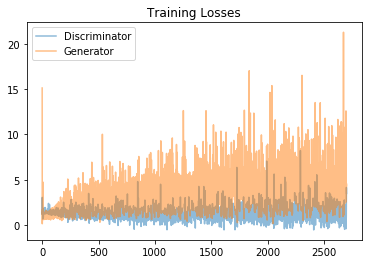

In [19]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [20]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

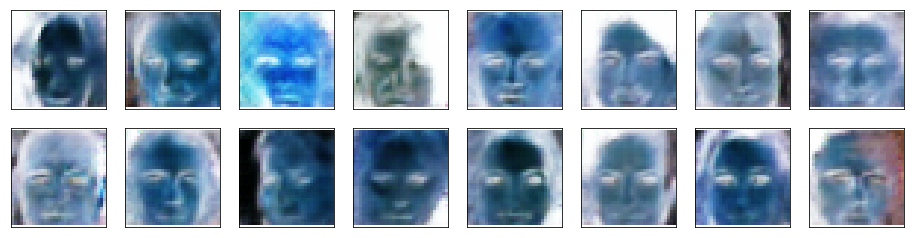

In [24]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.